Calculation of rewards for the main branch. Currently all our mechs have the same main branch

In [1]:
"""Script for optimization of a single topology"""
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import VelocityReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward

from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot, jps_graph2pinocchio_robot_3d_constraints

#### Setup trajectories 

If the trajectory has an unreachable point the cell with reward calculation will fail!

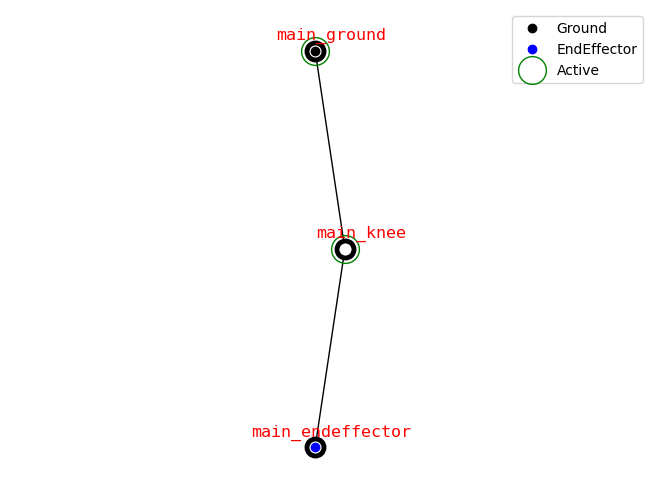

In [2]:
tp = TopologyManager2D()
# creates ground connection
main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=True, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))

tp.set_mutation_ranges()
graph = tp.get_graph(tp.generate_central_from_mutation_range())
draw_joint_point(graph)

#### Characteristics to be calculated

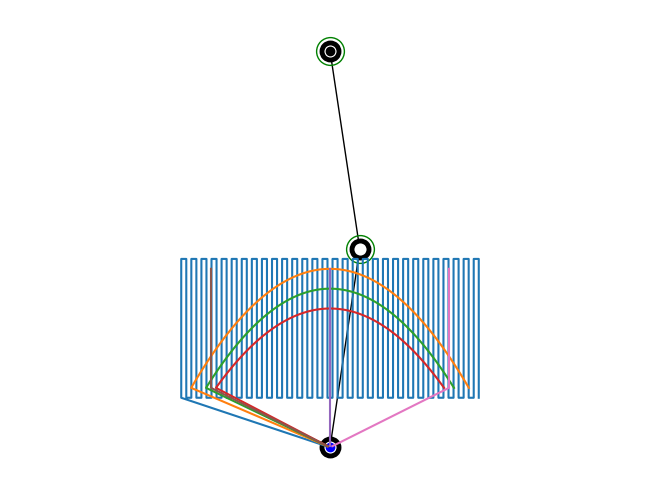

In [3]:
from auto_robot_design.utils.configs import get_standard_builder, get_standard_crag, get_standard_trajectories, get_standard_rewards, get_mesh_builder
builder = get_standard_builder()
crag = get_standard_crag(open_loop=True)
trajectories = get_standard_trajectories()
rewards = get_standard_rewards()


draw_joint_point(graph, draw_labels=False)
for _, trajectory in trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

#plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [4]:
print(trajectories.keys())
print(rewards.keys())

dict_keys(['workspace', 'step1', 'step2', 'step3', 'central_vertical', 'left_vertical', 'right_vertical'])
dict_keys(['mass', 'actuated_inertia_matrix', 'z_imf', 'trajectory_manipulability', 'manipulability', 'min_manipulability', 'min_force', 'trajectory_zrr', 'dexterity', 'trajectory_acceleration', 'min_acceleration', 'mean_heavy_lifting', 'min_heavy_lifting'])


#### set the rewards and weights

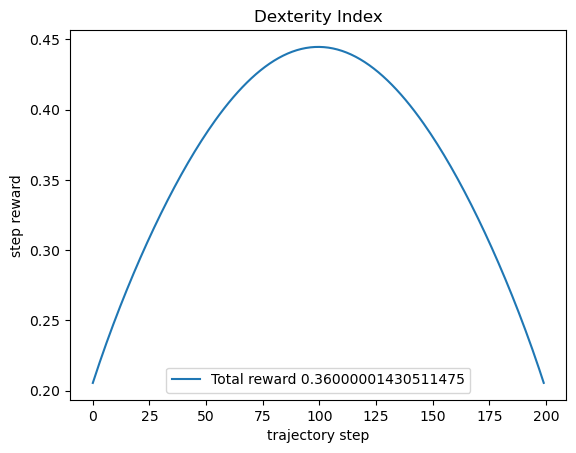

In [8]:
trajectory_name = 'step3'
reward_name = 'dexterity'
trajectory = trajectories[trajectory_name]
error_calculator = PositioningErrorCalculator(jacobian_key="Manip_Jacobian")
soft_constraint = PositioningConstrain(error_calculator=error_calculator, points=[trajectory])
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constrain_error, results = soft_constraint.calculate_constrain_error(crag, fixed_robot, free_robot)
results = results[0]
reward, reward_list = rewards[reward_name].calculate(results[0], results[1], results[2], Actuator = builder.actuator['default'])
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory step')
plt.ylabel('step reward')
plt.title(rewards[reward_name].reward_name)
plt.legend([f'Total reward {round(reward,2)}'])
plt.show()

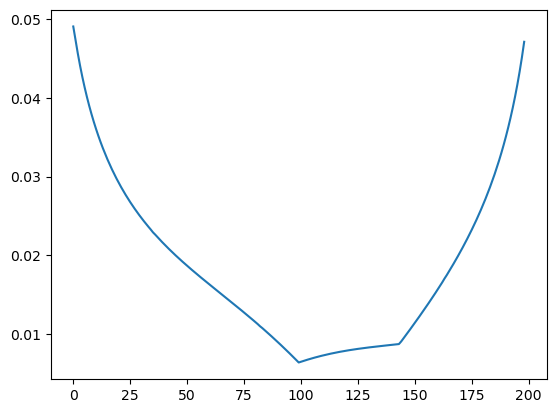

In [6]:
plt.plot(np.sum(np.abs(np.diff(results[2]['q'], axis=0)),axis=1))

In [7]:
import ipywidgets as widgets
import meshcat
from pinocchio.visualize import MeshcatVisualizer
from IPython.display import display, clear_output, HTML, IFrame, Image
from auto_robot_design.description.mesh_builder.urdf_creater import (
    URDFMeshCreator,
    MeshCreator,
)
from auto_robot_design.description.mesh_builder.mesh_builder import (
    MeshBuilder,
    jps_graph2pinocchio_meshes_robot,
)
import pinocchio as pin
import time
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager


mesh_builder = get_mesh_builder()
output = widgets.Output()

fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
visualizer = MeshcatVisualizer(
    fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model
)
with output:
    visualizer.viewer = meshcat.Visualizer()
visualizer.viewer["/Background"].set_property("visible", False)
visualizer.viewer["/Grid"].set_property("visible", False)
visualizer.viewer["/Axes"].set_property("visible", False)
visualizer.viewer["/Cameras/default/rotated/<object>"].set_property(
    "position", [0, 0.0, 0.8]
)
visualizer.clean()
visualizer.loadViewerModel()
visualizer.display(pin.neutral(fixed_robot.model))
with output:
    output.clear_output(wait=True)
    display(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

#output.append_display_data(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

def run_simulation(b):
    global tp
    ik_manager = TrajectoryIKManager()
    ik_manager.set_solver('Open_Loop')
    # fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)
    fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
    ik_manager.register_model(
        fixed_robot.model, fixed_robot.constraint_models, fixed_robot.visual_model
    )
    #ik_manager.set_solver("Closed_Loop_PI")
    poses, q_fixed, constraint_errors, reach_array = ik_manager.follow_trajectory(
        trajectory, viz=visualizer
    )
    time.sleep(0.5)
    visualizer.display(pin.neutral(fixed_robot.model))

first_run_button = widgets.Button(description='run simulation', layout=widgets.Layout(width='200px', height='40px')) 
first_run_button.style.button_color = 'lightblue'
first_run_button.on_click(run_simulation)
display(output, first_run_button)


Output()

Button(description='run simulation', layout=Layout(height='40px', width='200px'), style=ButtonStyle(button_col…